In [ ]:
! nvidia-smi      

Wed Sep 21 15:52:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# path for loading data

In [ ]:
# using Google drive path'

# 코랩을 이용하지 않을 경우 필요하지 않음.
from google.colab import drive
drive.mount('/content/drive')

# path 넣어주기
x_path = 'drive/MyDrive/X_data.npy'
x_2d_path = 'drive/MyDrive/X_2d_data.npy'
y_path = 'drive/MyDrive/Y_data.npy'

Mounted at /content/drive


# Import libraries, Set device

In [ ]:
# import libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import random
import torch.nn.functional as F
import sklearn.metrics as metrics
import os 
from torchvision.models import resnet18
import torchvision.transforms.functional as f

# set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
def seed(seed = 1):
    random.seed(seed)
    np.random.seed(seed) 
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic=True
    os.environ["PYTHONHASHSEED"] = str(seed)

seed(42)

g = torch.Generator()
g.manual_seed(42)

# functions for data preprocessing

In [ ]:
def get_0_164_ind(tensor, threshold):
    """code for removing data containing missing values, not used.
    """
    ind_0_164 = []
    for i in range(tensor.shape[0]):
        ind_0_cnt = (tensor[i, :] == 0.0).sum()
        ind_164_cnt = (tensor[i, :] == 164.0).sum()
        nvalue_cnt = ind_0_cnt + ind_164_cnt
        if nvalue_cnt.item() == 0:
            ind_0_164.append(i)  
    return ind_0_164

def dropNaN(X, Y):
    """drop data without target label
    """
    drop_ind = Y == -1
    return np.delete(X, drop_ind, axis=0), np.delete(Y, drop_ind)

def Normalization(X):
    """for data normalization
    """
    X_mean = X.mean(dim=1)
    X_std = X.std(dim=1)
    temp = np.zeros_like(X)
    for i in range(X.shape[0]):
        temp[i, :] = (X[i, :] - X_mean[i]) / X_std[i]
    return torch.Tensor(temp)

def one_hot(Y):
    """for one-hot encoding
    """
    Y_hot = np.zeros((len(Y), 3))
    for i, d in enumerate(Y):
        Y_hot[i, int(d)-1] = 1
    return torch.Tensor(Y_hot)

# loading data

In [ ]:
X = torch.FloatTensor(np.load(x_path))
X_2d = torch.FloatTensor(np.load(x_2d_path))
Y = np.load(y_path)

# data preprocessing
- drop unlabeled data
- Normalization (only 1d since 2d data's values are in [0, 1])
- one hot encoding
- data split
- data augmentation (considered, but unused)


In [ ]:
# drop data without target label
X_2d, _ = dropNaN(X_2d, Y)
X, Y = dropNaN(X, Y)
X_2d = X_2d / 255
X_2d = f.normalize(X_2d, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# Normalization
X = Normalization(X)

all_X, all_Y = X, Y  # for test 1d vs 2d

# target value ratio
print(f'label 1: {100*(Y==1).sum()/len(Y):.3f}%, label 2: {100*(Y==2).sum()/len(Y):.3f}%, label 3: {100*(Y==3).sum()/len(Y):.3f}%\n')

# one hot encoding
Y = one_hot(Y)
print(f'X size : {X.size()}\n')
print(f'Y size : {Y.size()}\n')

# data split with ratio 8 : 2
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=1, stratify=Y)

# data augmentation, not used
"""
add_ind = Y_train.argmax(dim=1) != 2
X_train = torch.cat( (X_train, X_train[add_ind, :]), dim=0)
Y_train = np.concatenate( (Y_train, Y_train[add_ind, :]))
"""

# train, test 
print(f'Train set 개수: {X_train.shape[0]}개\n')
print(f'Test set 개수: {X_test.shape[0]}개\n')

for i in range(3):
    print(f'label {i}: {100*(Y_train.argmax(axis=1)==i).sum()/len(Y_train):.3f}%')

label 1: 8.048%, label 2: 8.646%, label 3: 83.306%

X size : torch.Size([1839, 4192])

Y size : torch.Size([1839, 3])

Train set 개수: 1471개

Test set 개수: 368개

label 0: 8.022%
label 1: 8.634%
label 2: 83.345%


# Dataset, Dataloader for training 1d resnet
- only for train, not used for 1d vs 2d

In [ ]:
# Dataset, DataLoader 
class Dset(Dataset):
    def __init__(self, x_data, y_data):
        super(Dset, self).__init__()
        self.x = x_data
        self.y = y_data
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return len(self.x)
    
train_dset = Dset(X_train, Y_train)
train_dataloader = DataLoader(train_dset, batch_size=32, shuffle=True, generator=g)

test_dset = Dset(X_test, Y_test)
test_dataloader = DataLoader(test_dset, batch_size=len(test_dset), shuffle=False, generator=g)

# Early stopping class
- only for train, not used for 1d vs 2d
- used to prevent overfitting

In [ ]:
# 조기 종료 클래스
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', save=True):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.save = save

    def __call__(self, val_loss, model, global_best_accuracy, mode='Min'):
        if mode == 'Min':
            score = -val_loss
        else:
            score = val_loss
        if self.best_score is None:
            self.best_score = score
            if val_loss > global_best_accuracy:
                self.save_checkpoint(val_loss, model)
            else:
                print('점수는 나아졌으나 전체 모델 점수보단 덜함.')
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            if val_loss > global_best_accuracy:
                self.save_checkpoint(val_loss, model)
            else:
                print('점수는 나아졌으나 전체 모델 점수보단 덜함.')
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        if self.save:
            torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# 1D CNN Model
- It is not used because the resnet model has better performance.


In [ ]:

class cnn_1d(nn.Module):
    def __init__(self):
        super(cnn_1d, self).__init__()
        self.activation = nn.ReLU()
        self.layer1 = nn.Sequential(  
                         nn.Conv1d(1, 128, kernel_size=7, stride=1, bias=True, padding=3),   # (B, 128, 4192)
                         self.activation,
                         nn.Dropout(0.4),
                         nn.Conv1d(128, 64, kernel_size=3, stride=1, bias=True, padding=1),  # (B, 16, 4192)
                         self.activation,
                         nn.Dropout(0.3),
                         nn.Conv1d(64, 32, kernel_size=3, stride=1, bias=True, padding=1),  # (B, 8, 4192)
                         self.activation,
                         nn.Dropout(0.3),
                         nn.Conv1d(32, 128, kernel_size=3, stride=1, bias=True, padding=1)  
        )  
        self.flat = nn.Flatten()
        self.layer2 = nn.Sequential(
                         nn.Linear(536576, 512, bias=True),
                         self.activation,
                         nn.Dropout(0.3),
                         nn.Linear(512, 256, bias=True),
                         self.activation,
                         nn.Linear(256, 128, bias=True),
                         self.activation,
                         nn.Dropout(0.3),
                         nn.Linear(128, 32, bias=True),
                         self.activation,
                         nn.BatchNorm1d(32),
                         nn.Dropout(0.3),
                         nn.Linear(32, 3, bias=True)
                         #nn.Softmax(dim=1)
        )
        # self.test = nn.Conv1d(1, 128, kernel_size=1)

    
    def forward(self, x):
        out = self.layer1(x)
        out = F.relu(out)
        out = self.flat(out)
        out = self.layer2(out)
        return out

model = cnn_1d()
t = torch.zeros((2, 1, 4192))
t = model(t)
print(t)
del t

tensor([[ 0.1945, -1.1080,  0.4560],
        [ 0.1058,  0.6208,  0.1074]], grad_fn=<AddmmBackward0>)


# 1D ResNet18
- actual structure is slightly different from ResNet18 since I made it myself, and the input size & dimension is different.

In [ ]:
class Block_B(nn.Module):
    def __init__(self):
        super(Block_B, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU()
    ) 

    def forward(self, x):
        return self.layer(x)

class Block_C(nn.Module):
    def __init__(self, input_size):
        super(Block_C, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv1d(input_size, 128, kernel_size=3, stride=1, padding=1),  # 28 * 28
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),  # 28 * 28
            nn.BatchNorm1d(128),
            nn.ReLU()
    ) 

    def forward(self, x):
        return self.layer(x)

class Block_D(nn.Module):
    def __init__(self, input_size):
        super(Block_D, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv1d(input_size, 256, kernel_size=3, stride=1, padding=1),  # 28 * 28
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),  # 28 * 28
            nn.BatchNorm1d(256),
            nn.ReLU()
    ) 

    def forward(self, x):
        return self.layer(x)       

class Block_E(nn.Module):
    def __init__(self, input_size):
        super(Block_E, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv1d(input_size, 512, kernel_size=3, stride=1, padding=1),  # 28 * 28
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),  # 28 * 28
            nn.BatchNorm1d(512),
            nn.ReLU()
    ) 

    def forward(self, x):
        return self.layer(x)  

class Resnet1d(nn.Module):  # inpurt (B, 1, 4192)
    def __init__(self):
        super(Resnet1d, self).__init__()
        self.Block_A = nn.Sequential(
                nn.Conv1d(1, 64, kernel_size=8, stride=2, padding=3),  # (64, 2096)
                nn.BatchNorm1d(64),
                nn.ReLU(),
                nn.MaxPool1d(3, 2, 1)  # 절반으로 만드는 layer
        )  # (B, 64, 1048)
        self.Block_B_1 = Block_B()
        self.Block_B_2 = Block_B()


        self.Block_C_1 = Block_C(64)
        self.Block_C_2 = Block_C(128)
        self.conv1x1_C = nn.Conv1d(64, 128, kernel_size=1, stride=1, padding=0)

        self.Block_D_1 = Block_D(128)
        self.Block_D_2 = Block_D(256)
        self.conv1x1_D = nn.Conv1d(128, 256, kernel_size=1, stride=1, padding=0)

        self.Block_E_1 = Block_E(256)
        self.Block_E_2 = Block_E(512)
        self.conv1x1_E = nn.Conv1d(256, 512, kernel_size=1, stride=1, padding=0)

        self.fc_layer = nn.Sequential(
              nn.AdaptiveAvgPool1d(7),
              nn.Flatten(),
              nn.Linear(3584, 3)
        )
    def forward(self, x):
      out = self.Block_A(x)

      out = F.relu(self.Block_B_1(out) + out)
      out = F.relu(self.Block_B_2(out) + out)
      out = F.max_pool1d(out, 3, 2, 1)

      out = F.relu(self.Block_C_1(out) + self.conv1x1_C(out))
      out = F.relu(self.Block_C_2(out) + out)
      out = F.max_pool1d(out, 3, 2, 1)

      out = F.relu(self.Block_D_1(out) + self.conv1x1_D(out))
      out = F.relu(self.Block_D_2(out) + out)
      out = F.max_pool1d(out, 3, 2, 1)

      out = F.relu(self.Block_E_1(out) + self.conv1x1_E(out))

      out = F.relu(self.Block_E_2(out) + out)
      out = F.max_pool1d(out, 3, 2, 1)

      out = self.fc_layer(out)
      
      return out

# test
t = torch.zeros((1, 1, 4192))

res = Resnet1d()

print(res(t))

tensor([[-0.2307, -0.8111, -0.0020]], grad_fn=<AddmmBackward0>)


# functions & variables for 1D vs 2D

In [ ]:
# for grid search
batch_size_grid = [8]*3 + [16]*3 + [32]*3
batch_size_grid *= 2
lr_grid = [1e-5, 1e-4, 1e-3]*6
dim_grid = ['1D']*9 + ['2D']*9
grid_list = zip(batch_size_grid, lr_grid, dim_grid)

# for KFold
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 5)

skf.get_n_splits(all_X, all_Y)

def train_test_with_index(X, Y, test_ind):
    train_ind = list(set(range(len(Y))) - set(test_ind))
    return X[train_ind], X[test_ind], Y[train_ind], Y[test_ind]

# Data Recording Array



arr_name_list = ['accuracy_epoch_50', 'accuracy_epoch_100', 'accuracy_max',
                 'sensitivity_epoch_50', 'sensitivity_epoch_100', 'sensitivity_max',
                 'specificity_epoch_50', 'specificity_epoch_100', 'specificity_max']

def dim_model_select(dim):
    if dim == '1D':
        model = Resnet1d()
    else:
        model = resnet18(pretrained=True)
        model.fc = nn.Linear(in_features = 512, out_features = 3)
        model.to(device)
    return model

def one_hot_to_binary(arr):
    temp = arr[:, :2].argmax(dim=1).reshape(-1, 1)
    return torch.Tensor(np.concatenate((temp, arr[:, 2].reshape(-1, 1)), axis=1))

def save_arr(*arrays):
    for i, arr in enumerate(arrays):
        np.save(f'drive/MyDrive/temp_arrays/{arr_name_list[i]}.npy', arr)

# For test 1d vs 2d
- 1d data : extracted time series data
- 2d data : 2d cropped data with 3 channel (RGB)
- 1d model : 1d resnet18 (not pretrained)
- 2d model : 2d resnet18 bulit in torchvision (pretrained)

> Since there is not enough data, use 5 fold (8 : 2)


- hyperparameters:
        batch_size = {8, 16, 32},
        learning_rate = {1e-3, 1e-4, 1e-5}
        dimension = {'1D', '2D'}
        (3*3*2 = 18 combinations)

- recording features at each fold + average of 5 fold
        accuracy at 50 epoch, 100 epoch, largest value in entire epoch
        sensitivity at 50 epoch, 100 epoch, largest value in entire epoch
        specificity at 50 epoch, 100 epoch, largest value in entire epoch




In [ ]:
all_Y_onehot = one_hot(all_Y)  
recorded_cnt = 0 # change this to skip recorded cnt
current_cnt = 0

if recorded_cnt == -1:
    accuracy_epoch_50 = np.zeros((18, 6))  # 18 grid search / 5 fold, avg
    accuracy_epoch_100 = np.zeros((18, 6))
    accuracy_max = np.zeros((18, 6))

    sensitivity_epoch_50 = np.zeros((18, 6))  # 18 grid search / 5 fold, avg
    sensitivity_epoch_100 = np.zeros((18, 6))
    sensitivity_max = np.zeros((18, 6))

    specificity_epoch_50 = np.zeros((18, 6))  # 18 grid search / 5 fold, avg
    specificity_epoch_100 = np.zeros((18, 6))
    specificity_max = np.zeros((18, 6))
else:
    accuracy_epoch_50 = np.load('drive/MyDrive/temp_arrays/accuracy_epoch_50.npy')  # 18 grid search / 5 fold, avg
    accuracy_epoch_100 = np.load('drive/MyDrive/temp_arrays/accuracy_epoch_100.npy')
    accuracy_max = np.load('drive/MyDrive/temp_arrays/accuracy_max.npy')

    sensitivity_epoch_50 = np.load('drive/MyDrive/temp_arrays/sensitivity_epoch_50.npy')  # 18 grid search / 5 fold, avg
    sensitivity_epoch_100 = np.load('drive/MyDrive/temp_arrays/sensitivity_epoch_100.npy')
    sensitivity_max = np.load('drive/MyDrive/temp_arrays/sensitivity_max.npy')

    specificity_epoch_50 = np.load('drive/MyDrive/temp_arrays/specificity_epoch_50.npy')  # 18 grid search / 5 fold, avg
    specificity_epoch_100 = np.load('drive/MyDrive/temp_arrays/specificity_epoch_100.npy')
    specificity_max = np.load('drive/MyDrive/temp_arrays/specificity_max.npy')

grid_list = zip(batch_size_grid, lr_grid, dim_grid)
for batch_size, lr, dim in grid_list:
    if current_cnt <= recorded_cnt:
        print(batch_size, lr, dim)
        current_cnt += 1
        continue
    print(f'lr: {lr}, batch_size: {batch_size}, dim: {dim}, cnt: {current_cnt}')
    fold = -1
    for _, test_index in skf.split(all_X, all_Y):
        print(f'fold {fold+1}')
        fold += 1
        X_in = X if dim == '1D' else X_2d
        X_train, X_test, Y_train, Y_test = train_test_with_index(X_in, 
                                                    all_Y_onehot, test_index)
        X_train = X_train.to(device)
        X_test = X_test.to(device)
        Y_train = Y_train.to(device)
        Y_test = Y_test.to(device)
        model = dim_model_select(dim).to(device)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        train_dset = Dset(X_train, Y_train)
        test_dset = Dset(X_test, Y_test)
        train_dataloader = DataLoader(train_dset, batch_size=batch_size, 
                                      shuffle=True)   
        test_dataloader = DataLoader(test_dset, batch_size=len(test_dset), 
                                     shuffle=False)   
        max_accuracy, max_sensitivity, max_specificity  = 0, 0, 0

        # Train with current fold
        for epoch in range(1, 101):
            model.train()
            print(f'epoch {epoch}', end=' ')
            for x_batch, y_batch in train_dataloader:
                if dim == '1D':
                    x_batch = x_batch.unsqueeze(1).to(device)
                y_batch = y_batch.to(device)
                criterion = model(x_batch)
                cost = F.cross_entropy(criterion, y_batch)
                optimizer.zero_grad()
                cost.backward()
                optimizer.step()
                del x_batch, y_batch
                torch.cuda.empty_cache()
            
            print('\n'+'-'*20)

            print(f'cost={cost.item()}')

            # Val set test
            model.eval()
            with torch.no_grad():
                for x_batch, y_batch in test_dataloader:
                    if dim == '1D':
                        x_batch = x_batch.unsqueeze(1).to(device)
                    y_batch = y_batch.to(device)
                    test_criterion = model(x_batch)
                    test_cost = F.cross_entropy(test_criterion, y_batch)
                    print(f'test cost={test_cost.item()}')
                    acc = sum(test_criterion.argmax(dim=1) == y_batch.argmax(dim=1)) / len(test_dset)
                    print(f'test accurary={100*acc.item()}%')
                    y_batch = y_batch.to('cpu')
                    y_batch = one_hot_to_binary(y_batch)
                    test_criterion = test_criterion.to('cpu')
                    test_criterion = one_hot_to_binary(test_criterion)
                    tp, fn, fp, tn = metrics.confusion_matrix(y_batch.argmax(dim=1), test_criterion.argmax(dim=1)).ravel()
                    specificity = tn / (tn + fp)
                    print(tn, fp, fn, tp)
                    sensitivity = tp / (tp + fn)
                    print(f'specificity={specificity:.2f}, sensitivity={sensitivity:.2f}')
                    del x_batch, y_batch
                    torch.cuda.empty_cache()
                
                # recording data
                accuracy_max[current_cnt, fold] = max(accuracy_max[current_cnt, fold], acc)
                sensitivity_max[current_cnt, fold] = max(sensitivity_max[current_cnt, fold], sensitivity)
                specificity_max[current_cnt, fold] = max(specificity_max[current_cnt, fold], specificity)

                if epoch == 50:
                    accuracy_epoch_50[current_cnt, fold] = acc
                    sensitivity_epoch_50[current_cnt, fold] = sensitivity
                    specificity_epoch_50[current_cnt, fold] = specificity
                
                if epoch == 100:
                    accuracy_epoch_100[current_cnt, fold] = acc
                    sensitivity_epoch_100[current_cnt, fold] = sensitivity
                    specificity_epoch_100[current_cnt, fold] = specificity
                torch.cuda.empty_cache()
             
        save_arr(accuracy_epoch_50, 
                accuracy_epoch_100, 
                accuracy_max,
                sensitivity_epoch_50,
                sensitivity_epoch_100, 
                sensitivity_max,
                specificity_epoch_50,
                specificity_epoch_100,
                specificity_max)

    print(f'recorded_cnt = {current_cnt}')
    current_cnt += 1
        

    


8 1e-05 1D
lr: 0.0001, batch_size: 8, dim: 1D, cnt: 1
fold 0
epoch 1 
--------------------
cost=0.16430625319480896
test cost=0.5788634419441223
test accurary=77.71739363670349%
306 1 58 3
specificity=1.00, sensitivity=0.05
epoch 2 

KeyboardInterrupt: ignored

이 아래부터는 1d vs 2d가 아닌, 1d resnet 학습을 목적으로 함.

In [ ]:
# Train 
total_best_accuracy = 0
best_train_score = []
best_test_score = []
best_test_accuracy = []

for lr, batch_size in zip(random_learning_rate, random_batch_size):
    print(f'lr: {lr}, batch_size={batch_size}')
    model_best_accuracy=0
    torch.cuda.empty_cache()
    model = Resnet1d().to(device)
    early_stopping = EarlyStopping(patience=30, verbose = True)
    train_score = []
    test_score = []
    test_accuracy = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_dataloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)   
    for epoch in range(2000):
        model.train()
        cnt = 0
        print(f'epoch {epoch+1}', end=' ')
        for x_batch, y_batch in train_dataloader:
            cnt+=1
            x_batch = x_batch.unsqueeze(1).to(device)
            y_batch = y_batch.to(device)
            # print(x_batch.size())
            criterion = model(x_batch)
            # print(criterion.size())
            # weight = torch.Tensor([13, 13, 1]).to(device)
            # weight = torch.Tensor([4, 4, 1]).to(device)
            cost = F.cross_entropy(criterion, y_batch) # , weight=weight)
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
            del x_batch
            del y_batch
            # del weight
            torch.cuda.empty_cache()
        
        print('\n'+'-'*20)
        print(f'cost={cost.item()}')
        train_score.append(cost.item())
        model.eval()

        with torch.no_grad():
            for x_batch, y_batch in test_dataloader:
                x_batch = x_batch.unsqueeze(1).to(device)
                y_batch = y_batch.to(device)
                test_criterion = model(x_batch)
                
                test_cost = F.cross_entropy(test_criterion, y_batch)
                print(f'test cost={test_cost.item()}')

                acc = sum(test_criterion.argmax(dim=1) == y_batch.argmax(dim=1)) / len(test_dset)
                print(f'test accurary={100*acc.item()}%')
                print(f'ratio: {(test_criterion.argmax(dim=1) == 0).sum()} : {(test_criterion.argmax(dim=1) == 1).sum()} : {(test_criterion.argmax(dim=1) == 2).sum()}')
                del x_batch
                del y_batch
                torch.cuda.empty_cache()
            test_score.append(test_cost.item())
            test_accuracy.append(100*acc.item())
            if acc > model_best_accuracy:
                model_best_accuracy = acc
            print('-'*20)
            model.to('cpu')
            early_stopping(acc.item(), model, total_best_accuracy, mode='Max')
            model.to('cuda')
            if early_stopping.early_stop:
                if model_best_accuracy > total_best_accuracy:
                    total_best_accuracy = model_best_accuracy
                    best_train_score = train_score[:]
                    best_test_score = test_score[:]
                    best_test_accuracy = test_accuracy[:]
                    print(f'lr: {lr}, batch_size={batch_size} is best')
                print(f"Early stopping, current best acc:{total_best_accuracy}")
                break
            torch.cuda.empty_cache()
    


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
test accurary=93.76218318939209%
ratio: 37 : 38 : 438
--------------------
EarlyStopping counter: 7 out of 30
epoch 71 
--------------------
cost=0.008539258502423763
test cost=0.22200907766819
test accurary=92.98245906829834%
ratio: 37 : 35 : 441
--------------------
EarlyStopping counter: 8 out of 30
epoch 72 
--------------------
cost=0.009263938292860985
test cost=0.2283133864402771
test accurary=93.37232112884521%
ratio: 35 : 36 : 442
--------------------
EarlyStopping counter: 9 out of 30
epoch 73 
--------------------
cost=0.014207495376467705
test cost=0.21400326490402222
test accurary=93.76218318939209%
ratio: 38 : 37 : 438
--------------------
EarlyStopping counter: 10 out of 30
epoch 74 
--------------------
cost=0.003216516925022006
test cost=0.23291786015033722
test accurary=93.17739009857178%
ratio: 37 : 34 : 442
--------------------
EarlyStopping counter: 11 out of 30
epoch 75 
--------------------
cost=0.0020321772899478674
test cost=

KeyboardInterrupt: ignored

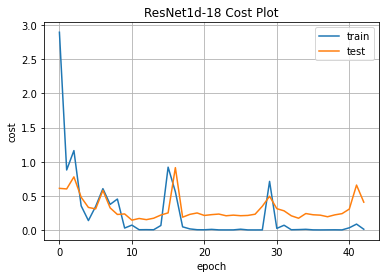

In [ ]:
import matplotlib.pyplot as plt

plt.plot(best_train_score, label='train')
plt.plot(best_test_score, label='test')
plt.title('ResNet1d-18 Cost Plot')
plt.xlabel('epoch')
plt.ylabel('cost')
plt.grid()
plt.legend()
plt.show()

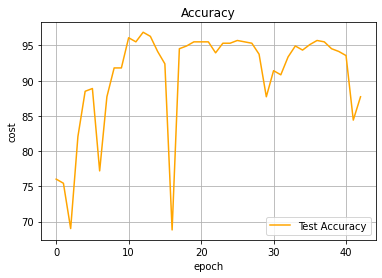

In [ ]:

plt.plot(best_test_accuracy, color='orange', label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('cost')
plt.grid()
plt.legend()
plt.show()

In [ ]:
best_model = Resnet1d()
best_model_dict = torch.load('checkpoint_9688.pt')
best_model.load_state_dict(best_model_dict)
torch.save(best_model, 'resnet1d_9688.pt')

In [ ]:
# 최상의 모델 평가
torch.cuda.empty_cache()
best_model
best_model.eval()

best_criterion = best_model(X_test.unsqueeze(1))
best_criterion
acc = sum(best_criterion.argmax(dim=1) == Y_test.argmax(dim=1)).item() / Y_test.shape[0]
print(f'test accurary: {100*acc}%')
print(Y_test.shape[0])
print(best_criterion.argmax(dim=1))
print(Y_test.argmax(dim=1))
for i in range(3):
    print(f'{i}번 label')
    print(f'실제: {(Y_test.argmax(dim=1) == i).sum()}개')
    print(f'예측: {(best_criterion.argmax(dim=1) == i).sum()}개')


test accurary: 96.88109161793372%
513
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1,
        1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2,
        0, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2,
        2, 2, 2, 2, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 0, 2, 0, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
        2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1,
        2, 1, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 0, 2, 2, 2, 1, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
  

[[38, 0, 2], [0, 41, 1], [6, 7, 418]]


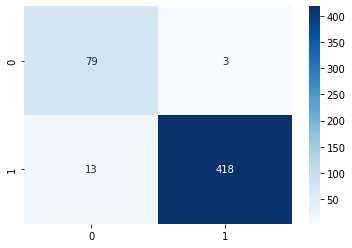

In [ ]:
a = best_criterion.argmax(dim=1)
b = Y_test.argmax(dim=1)

L = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]  # 첫 인덱스는 x, 다음 인덱스는 y
for i, j in zip(a, b):
  L[i][j] += 1  # [예측][실제]
print(L)

L = list((100 * np.array(L) / 513).round(2))

import seaborn as sns
L2 = [[79, 3],
      [13, 418]]
sns.heatmap(L2, annot=True, fmt='d', cmap='Blues')